<a href="https://colab.research.google.com/github/emilyswitzer/celeb-heights/blob/main/UpdatedCelebs_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

In [2]:
!unzip "/content/smallerwithpadding.zip" -d "/"

Archive:  /content/smallerwithpadding.zip
   creating: /content/train/
   creating: /content/train/162/
  inflating: /content/train/162/Barbara Hershey.jpg  
  inflating: /content/train/162/Carla Gallo.jpg  
  inflating: /content/train/162/Azita Ghanizada.jpg  
  inflating: /content/train/162/Anne Diamond.jpg  
  inflating: /content/train/162/Orla Brady.jpg  
  inflating: /content/train/162/Dina Manzo.jpg  
  inflating: /content/train/162/Olivia Munn.jpg  
  inflating: /content/train/162/Lauren Velez.jpg  
  inflating: /content/train/162/Nikki Reed.jpg  
  inflating: /content/train/162/Chloe Ferry.jpg  
  inflating: /content/train/162/Emily Hampshire.jpg  
  inflating: /content/train/162/Natalie Horler.jpg  
  inflating: /content/train/162/Meghan Heffern.jpg  
  inflating: /content/train/162/Carley Stenson.jpg  
  inflating: /content/train/162/Noomi Rapace.jpg  
  inflating: /content/train/162/Nikki Sanderson.jpg  
  inflating: /content/train/162/Crystal Hunt.jpg  
  inflating: /conten

In [6]:
!unzip "/content/train" -d "/a"

unzip:  cannot find or open /content/train, /content/train.zip or /content/train.ZIP.


In [7]:
import pathlib
import glob
import cv2
#data_dir = "train/"
data_dir = "/content/train/"
data_dir = pathlib.Path(data_dir)

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3661


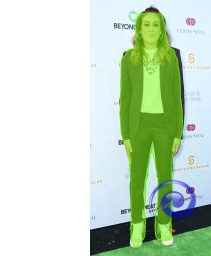

In [9]:
person = list(data_dir.glob('191/*'))
PIL.Image.open(str(person[10]))


In [12]:
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')

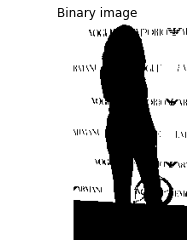

In [15]:
from skimage.filters import threshold_otsu
from skimage import data, color

chess_pieces_image = plt.imread('/content/train/154/Alessia Cara.jpg')

# Make the image grayscale using rgb2gray
chess_pieces_image_gray = color.rgb2gray(chess_pieces_image)

# Obtain the optimal threshold value with otsu
thresh = threshold_otsu(chess_pieces_image_gray)

# Apply thresholding to the image
binary = chess_pieces_image_gray > thresh

# Show the image
show_image(binary, 'Binary image')

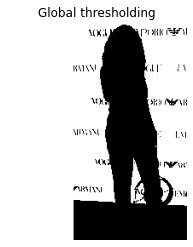

In [16]:
page_image = plt.imread('/content/train/154/Alessia Cara.jpg')

# Make the image grayscale using rgb2gray
page_image = color.rgb2gray(page_image)

# Obtain the optimal otsu global thresh value
global_thresh = threshold_otsu(page_image)

# Obtain the binary image by applying global thresholding
binary_global = page_image > global_thresh

# Show the binary image obtained
show_image(binary_global, 'Global thresholding')

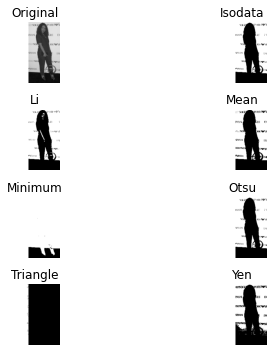

In [17]:
from skimage.filters import try_all_threshold

fruits_image = plt.imread('/content/train/154/Alessia Cara.jpg')

# Turn the fruits_image to grayscale
grayscale = color.rgb2gray(fruits_image)

# Use the try all method on the resulting grayscale image
fig, ax = try_all_threshold(grayscale, verbose=False);

In [56]:
import cv2
import torch
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

def load_model():
  model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
  model.eval()
  return model

def make_transparent_foreground(pic, mask):
  # split the image into channels
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  # add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # merge the alpha channel back
  alpha_im = cv2.merge([b, g, r, a], 4)
  # create a transparent background
  bg = np.zeros(alpha_im.shape)
  # setup the new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

  return foreground

def remove_background(model, input_file):
  input_image = Image.open(input_file)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)

  return foreground, bin_mask

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


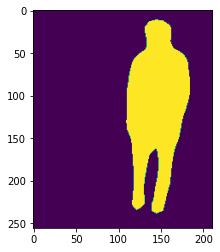

In [66]:
import numpy as np
deeplab_model = load_model()
foreground, bin_mask = remove_background(deeplab_model, '/content/train/156/Devery Jacobs.jpg')
plt.imshow(bin_mask)

In [151]:
import glob
import cv2 
import os
from os.path import basename
from imutils import paths
import imutils
import argparse
deeplab_model = load_model()

path = "/content/train/210/*"
newpath = "/content/train/210/"

for file in glob.glob(path):
 
   fil = basename(file)
   filname = os.path.splitext(fil)[0]
   foreground, bin_mask = remove_background(deeplab_model, file)

   cv2.imwrite(newpath+filname+'.jpg', bin_mask)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


# Load data using a Keras utility


## Create a dataset

In [157]:
from keras.callbacks import ModelCheckpoint

In [158]:
batch_size = 8
img_height = 256
img_width = 211

#img_height = 512
#img_width = 509

In [159]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
 # color_mode="grayscale",
  batch_size=batch_size)


Found 3661 files belonging to 78 classes.
Using 2197 files for training.


In [160]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
 #color_mode="grayscale",
  batch_size=batch_size)

Found 3661 files belonging to 78 classes.
Using 1464 files for validation.


In [161]:
class_names = train_ds.class_names
print(class_names)

['.ipynb_checkpoints', '106', '109', '111', '114', '116', '119', '121', '125', '127', '129', '130', '132', '139', '146', '147', '148', '149', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210']


## Visualize the data



In [163]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 256, 211, 3)
(8,)


## Standardize the data

The RGB channel values are in the `[0, 255]` range. To keep input values small  standardize values to be in the `[0, 1]` range.

In [164]:
normalization_layer = layers.Rescaling(1./255)

In [165]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


# Create the model



## Overfitting

## Data augmentation

In [42]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

#Create the model with Overfitting Solutions

In [175]:
num_classes = len(class_names)


model = Sequential([
 # data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
  #layers.Dense(1)
  
])

In [ ]:
num_classes = len(class_names)


model = Sequential([
  #data_augmentation,
  layers.Rescaling(1./255, input_shape=(256, 211, 3)),
  layers.Conv2D(32, 3,padding='same', activation='relu'),
  layers.Conv2D(32, 3,padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3,padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3,padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(1024 ,activation="relu"),
  layers.Dense(512 ,activation="relu"),
  layers.Dense(num_classes),
  layers.Dense(activation='softmax')
])

In [167]:
checkpoint = ModelCheckpoint('model.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 

x = list/ array of images
y - list/array of number (height)

## Compile and train the model

In [172]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
             metrics=['accuracy'])

In [180]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 256, 211, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 211, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 105, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 105, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 52, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 52, 64)       

In [177]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [178]:
epochs = 150
history = model.fit(
  train_ds,
  validation_data=val_ds,
 
 # callbacks=[checkpoint],
  epochs=epochs
)

Epoch 1/150
275/275 [==============================] - 24s 86ms/step - loss: 4.1934 - accuracy: 0.0423 - val_loss: 4.1036 - val_accuracy: 0.0342
Epoch 2/150
275/275 [==============================] - 23s 85ms/step - loss: 3.7425 - accuracy: 0.0824 - val_loss: 4.0858 - val_accuracy: 0.0294
Epoch 3/150
275/275 [==============================] - 24s 86ms/step - loss: 2.7727 - accuracy: 0.2467 - val_loss: 4.3090 - val_accuracy: 0.0437
Epoch 4/150
275/275 [==============================] - 24s 87ms/step - loss: 1.7812 - accuracy: 0.4893 - val_loss: 5.6371 - val_accuracy: 0.0389
Epoch 5/150
275/275 [==============================] - 24s 89ms/step - loss: 1.2553 - accuracy: 0.6381 - val_loss: 6.5914 - val_accuracy: 0.0417
Epoch 6/150
275/275 [==============================] - 25s 89ms/step - loss: 1.0480 - accuracy: 0.7064 - val_loss: 7.5980 - val_accuracy: 0.0362
Epoch 7/150
275/275 [==============================] - 25s 90ms/step - loss: 0.9123 - accuracy: 0.7337 - val_loss: 7.1832 - val_ac

## Visualize training results


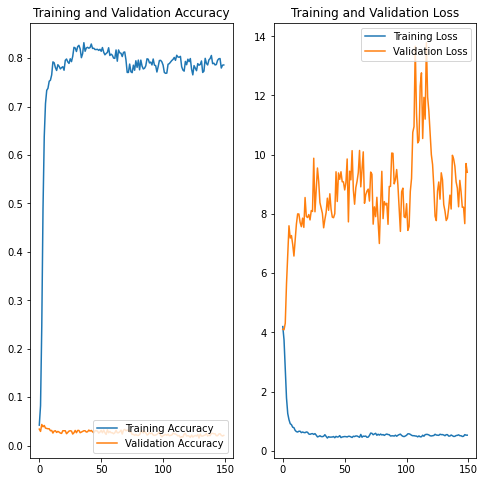

In [179]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on unseen data

In [60]:
!unzip "/content/unseen2.zip" -d "/content/unseen"

Archive:  /content/unseen2.zip
   creating: /content/unseen/content/unseen2/
  inflating: /content/unseen/content/unseen2/139.jpg  
  inflating: /content/unseen/content/unseen2/198.jpg  
  inflating: /content/unseen/content/unseen2/192.jpg  
  inflating: /content/unseen/content/unseen2/157.jpg  
  inflating: /content/unseen/content/unseen2/194.jpg  
  inflating: /content/unseen/content/unseen2/179.jpg  
  inflating: /content/unseen/content/unseen2/155.jpg  
  inflating: /content/unseen/content/unseen2/206.jpg  
  inflating: /content/unseen/content/unseen2/153.jpg  
  inflating: /content/unseen/content/unseen2/148.jpg  
  inflating: /content/unseen/content/unseen2/166.jpg  
  inflating: /content/unseen/content/unseen2/106.jpg  
  inflating: /content/unseen/content/unseen2/201.jpg  
  inflating: /content/unseen/content/unseen2/189.jpg  
  inflating: /content/unseen/content/unseen2/109.jpg  
  inflating: /content/unseen/content/unseen2/161.jpg  
  inflating: /content/unseen/content/unseen

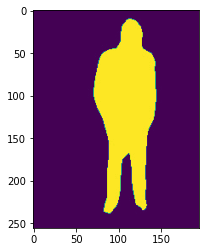

The person is 67.85 percent 201 cm 


In [189]:
import matplotlib.image as mpimg
img = mpimg.imread('/content/unseen/content/unseen2/203.jpg')
imgplot = plt.imshow(img)
plt.show()
sunflower_path = '/content/unseen/content/unseen2/203.jpg'

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])




print(
    "The person is {:.2f} percent {} cm "
    .format(100 * np.max(score),class_names[np.argmax(score)])
)